# Object Detection Model (for Pump Impellers)

Here, we fine-tune __RetinaNet__ (with __ResNet50__ Backbone) to detect the presence of pump impellers in images.

_This model is used to detect & segment out the pump impellers so that defects can be detected in them_

__Dataset:__ An augmented subset of [Submersible Pump Impeller Defect Dataset](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product) (so as to include multiple impellers in a single image, for effective detection)

## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/ME781/Project")

### Clone the RetinaNet repository & install all dependencies

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
os.chdir("keras-retinanet")
!pip install .

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 9 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (4207/4207), done.
Processing /content/drive/MyDrive/ME781/Project/keras-retinanet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp310-cp310-linux_x86_64.whl size=207901 sha256=b07d4cbb4607cf30a140b642d3dd3ff9536e4c7e1620e121de5f08830c268932
  Stored in directory: /root/.cache/pip/wheels/38/d4/03/e2b3d5f61e46dfbd12ab3a179aca6700b8f288e49be37434ce
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20457 sha256=2bc6112307070a03b4e7be39e0a7791f392cfa762557514296d0abaceb0d2b63
  Stored in directory: /root/.cache/pip/wheels/16/af/

In [ ]:
!python setup.py build_ext --inplace

/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running build_ext
copying build/lib.linux-x86_64-cpython-310/keras_retinanet/utils/compute_overlap.cpython-310-x86_64-linux-gnu.so -> keras_retinanet/utils


In [ ]:
!pip install keras_resnet

  Preparing metadata (setup.py) ... done
  Created wheel for keras_resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20457 sha256=17fa95bddc6c4b70e313f4acfc42f7c9cace5ce851e8afdd65f1034cd0303a67
  Stored in directory: /root/.cache/pip/wheels/16/af/88/a668b279c5eadbe55dcaf6207f09059135166cefb09088bacc
Successfully built keras_resnet


In [ ]:
import keras
import keras_resnet

## Dataset Preparation

A dataset of 12 images (these many are sufficient for object detection, since only 1 class is involved) is prepared, such that each image contains 1 or more pump impellers. All these images are annotated using [labelmg](https://github.com/tzutalin/labelImg).

This dataset is split into training & testing sets. For training, two CSV files are needed. The first one containing the path, bounding box and class name of each image (`train.csv`). The second file should only contain the class name and their mapping (`class.csv`).

The CSV file with annotations should contain one annotation per line. Images with multiple bounding boxes should use one row per bounding box. Note that indexing for pixel values starts at 0.

In [ ]:
from bs4 import BeautifulSoup
from imutils import paths
import argparse
import random

In [ ]:
annot_path = "/content/drive/My Drive/ME781/Project/object_detection/annotations"
images_path = "/content/drive/My Drive/ME781/Project/object_detection/images"
train_csv = "/content/drive/My Drive/ME781/Project/object_detection/train.csv"
test_csv = "/content/drive/My Drive/ME781/Project/object_detection/test.csv"
classes_csv = "/content/drive/My Drive/ME781/Project/object_detection/classes.csv"
train_test_split = 0.8

# grab all image paths then construct the training and testing split
imagePaths = list(paths.list_files(images_path))
random.shuffle(imagePaths)
i = int(len(imagePaths) * train_test_split)
trainImagePaths = imagePaths[:i]
testImagePaths = imagePaths[i:]

# create the list of datasets to build
dataset = [ ("train", trainImagePaths, train_csv),
            ("test", testImagePaths, test_csv)]

# initialize the set of classes we have
CLASSES = set()

# loop over the datasets
for (dType, imagePaths, outputCSV) in dataset:
    # load the contents
    print ("[INFO] creating '{}' set...".format(dType))
    print ("[INFO] {} total images in '{}' set".format(len(imagePaths), dType))

    # open the output CSV file
    csv = open(outputCSV, "w")

    # loop over the image paths
    for imagePath in imagePaths:
        # build the corresponding annotation path
        fname = imagePath.split(os.path.sep)[-1]
        fname = "{}.xml".format(fname[:fname.rfind(".")])
        annotPath = os.path.sep.join([annot_path, fname])

        # load the contents of the annotation file and buid the soup
        contents = open(annotPath).read()
        soup = BeautifulSoup(contents, "html.parser")

        # extract the image dimensions
        w = int(soup.find("width").string)
        h = int(soup.find("height").string)

        # loop over all object elements
        for o in soup.find_all("object"):
            #extract the label and bounding box coordinates
            label = o.find("name").string
            xMin = int(float(o.find("xmin").string))
            yMin = int(float(o.find("ymin").string))
            xMax = int(float(o.find("xmax").string))
            yMax = int(float(o.find("ymax").string))

            # truncate any bounding box coordinates that fall outside
            # the boundaries of the image
            xMin = max(0, xMin)
            yMin = max(0, yMin)
            xMax = min(w, xMax)
            yMax = min(h, yMax)

            # ignore the bounding boxes where the minimum values are larger
            # than the maximum values and vice-versa due to annotation errors
            if xMin >= xMax or yMin >= yMax:
                continue
            elif xMax <= xMin or yMax <= yMin:
                continue

            # write the image path, bb coordinates, label to the output CSV
            row = [os.path.abspath(imagePath),str(xMin), str(yMin), str(xMax),
                    str(yMax), str(label)]
            csv.write("{}\n".format(",".join(row)))

            # update the set of unique class labels
            CLASSES.add(label)

    # close the CSV file
    csv.close()

# write the classes to file
print("[INFO] writing classes...")
csv = open(classes_csv, "w")
rows = [",".join([c, str(i)]) for (i,c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()

[INFO] creating 'train' set...
[INFO] 20 total images in 'train' set
[INFO] creating 'test' set...
[INFO] 6 total images in 'test' set
[INFO] writing classes...


## Model Training (Fine-tuning)

In [ ]:
# Set the environment variable so as to enable the use of GPU
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
# Train the model for 20 epochs
# Model weights after each epoch are stored as snapshots in the `./snapshots/` directory

!python keras_retinanet/bin/train.py --steps 20 --epochs 200 csv "/content/drive/My Drive/ME781/Project/object_detection/train.csv" "/content/drive/My Drive/ME781/Project/object_detection/classes.csv"

2023-10-24 11:46:19.394691: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 11:46:19.394743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 11:46:19.394775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 11:46:20.523965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating model, this may take a second...
2023-10-24 11:46:24.677892: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original 

In [ ]:
# The best model among the snapshots has to be converted in a format which can be used for prediction.

!python keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_189.h5 "/content/drive/My Drive/ME781/Project/object_detection/pump_impeller_detection_retinanet.h5"

2023-10-24 12:42:35.259761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 12:42:35.259850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 12:42:35.259904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 12:42:36.834240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras forma

## Predictions by Model

In [ ]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [ ]:
model_path = "/content/drive/My Drive/ME781/Project/object_detection/pump_impeller_detection_retinanet.h5"
model = models.load_model(model_path, backbone_name='resnet50')

In [ ]:
THRESH_SCORE = 0.7                      # Threshold confidence above which the bounding box will be considered
labels_to_names = {0: "pump_impeller"}

# Function to identify pump impellers in an image & create bounding boxes around them
def img_inference(img_path):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < THRESH_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        print(caption)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

processing time:  4.492881774902344
pump_impeller 0.769


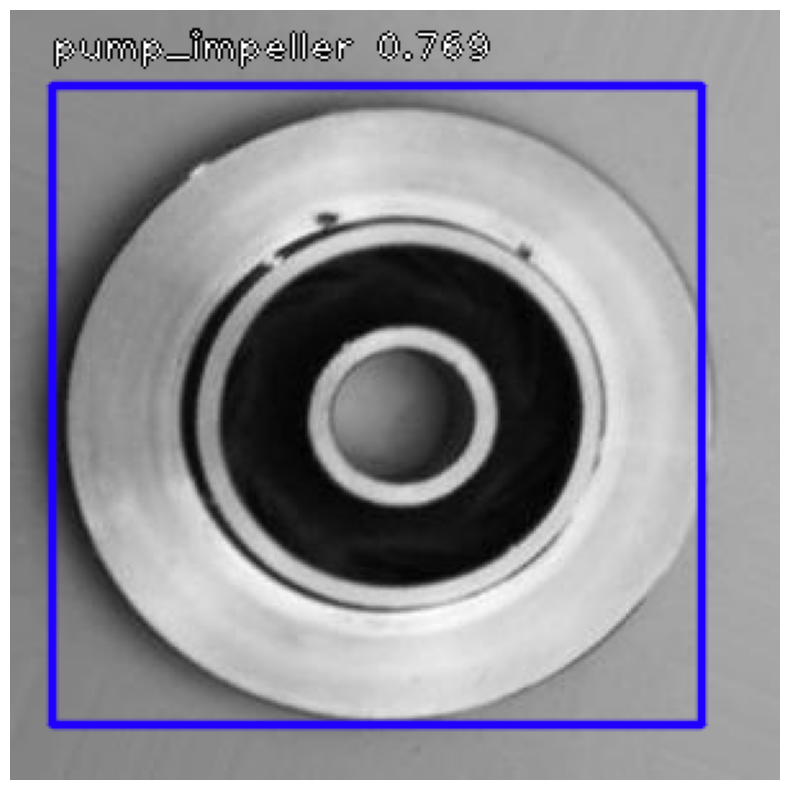

In [ ]:
img_inference("/content/drive/My Drive/ME781/Project/object_detection/images/img_10.jpeg")

processing time:  10.064706802368164
pump_impeller 0.768


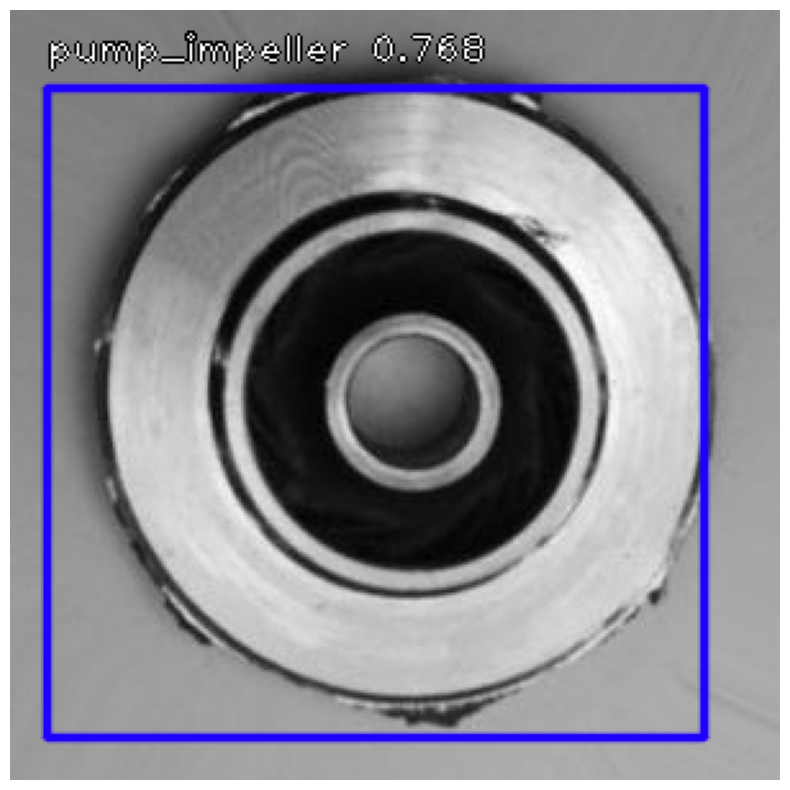

In [ ]:
img_inference("/content/drive/My Drive/ME781/Project/object_detection/images/img_11.jpeg")